# A review of clustering methods on tennis players
Data taken from: https://www.kaggle.com/gmadevs/atp-matches-dataset

In [1]:
import glob, os
import re
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, estimate_bandwidth, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from IPython.display import display
from itertools import cycle

## Data pre-processing

First, we get all the csv files' paths and then we merge them into a single dataframe.

In [2]:
files = glob.glob('/run/media/nick/Windows/Users/nvera/OneDrive/Documents/School/Unimi/DSE/Advanced Multivariate Statistics/Project/atp-matches-dataset/atp_matches_*.csv')
files.sort()

In [3]:
df = pd.concat(map(lambda file: pd.read_csv(file, usecols=['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'winner_rank', 'winner_rank_points', 'loser_id', 'loser_seed',
       'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'loser_rank', 'loser_rank_points', 'score', 'best_of',
       'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df',
       'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced']), files))

Let's get the true data we want, that is the player stats. They are:
    
    1. player_rank_best: the best rank the player ever reached
    2. player_1stServeWon_p: % of first serve win
    3. player_2ndServeWon_p: % of second serve win
    4. player_ace_p: % of aces
    5. player_df_p: % of double faults
    6. games_per_match: average number of games per match
    7. player_tbWon_p: % of tiebreaks won
    8. player_bpSaved_p: % of breakpoints saved
    9. opponent_bpBreak_p: % of breaking opponent's serves
    10. match_played: number of match played

In [4]:
def create_stats(x):
    player_rank_best = x.player_rank.min()
    player_1stServeWon_p = x.player_1stWon.sum() / x.player_1stIn.sum()
    player_2ndServeWon_p = x.player_2ndWon.sum() / x.player_2ndIn.sum()
    player_ace_p = x.player_ace.sum() / x.player_svpt.sum()
    player_df_p = x.player_df.sum() / x.player_svpt.sum()
    games_per_match = (x.player_games_won.sum() + x.opponent_games_won.sum()) / x.player_name.count()
    player_tbWon_p = x.player_tb_won.sum() / x.tiebreaks_total.sum()
    player_bpSaved_p = x.player_bpSaved.sum() / x.player_bpFaced.sum()
    opponent_bpBreak_p = 1 - x.opponent_bpSaved.sum() / x.opponent_bpFaced.sum()
    match_played = x.player_name.count()
    
    c = ['player_rank_best','player_1stServeWon_p','player_2ndServeWon_p','player_ace_p',
         'player_df_p','games_per_match', 'player_tbWon_p', 'player_bpSaved_p',
         'opponent_bpBreak_p', 'match_played']
    
    return pd.Series([player_rank_best, player_1stServeWon_p, player_2ndServeWon_p, player_ace_p,
                      player_df_p, games_per_match, player_tbWon_p, player_bpSaved_p, opponent_bpBreak_p,
                      match_played], index=c)

Drop the columns we do not need; drop the NA if present; create a new column that will contain the number of sets played and another one for the tie breaks.

Let's get at first:
    1. w_sets_won = The number of sets won by the winner
    2. l_sets_won = The number of sets won by the loser
    3. w_games_won = The number of games won by the winner
    4. l_games_won = The number of games won by the loser
    5. w_tb_won = The number of tie breaks won by the winner
    6. l_tb_won = The number of tie breaks won by the loser
    
Put what've got into the dataframe. Note that:
    1. w_2ndIn = number of second serves in for the winner
    2. l_2ndIn = number of second serves in for the loser
    3. w_svpt = number of service points played by the winner
    4. l_svpt = number of service points played by the loser
    5. w_1stIn = number of first serves in for the winner
    6. l_1stIn = number of first serves in for the loser
    7. w_df = number of double faults for the winner
    8. l_df = number of double faults for the loser
    
We now want to create a dataframe that will contain the stats for the best player. In order to do that, we create and merge two "opposite" dataframes: one that contains stats according to the victory while the other one according to the loss. To reduce the size of the dataframe, we just consider the players that have been in the top 20 and played more than 60 matches.

In [5]:
def preprocessing(df):
    df = df.loc[(df["score"] != "5-Jun")]
    df = df.drop(columns=["winner_seed", "winner_entry", "loser_seed", "loser_entry", "winner_ht", "loser_ht"])
    df = df.dropna()
    df = df.rename(columns={"draw_size": "drawsize"})
    df['num_sets'] = df['score'].apply(lambda x: len(re.findall(r"[0-9]-[0-9]|[1-9][0-9]-[1-9][0-9]|[1-9][0-9]-[0-9]|[0-9]-[1-9][0-9]", str(x))))
    df["tiebreaks_total"] = df["score"].apply(lambda x: len(re.findall(r"\(", str(x))))
    
    scores = df["score"].apply(lambda x: re.sub("\\([0-9]\\)|\\([1-9][0-9]\\)", "", str(x))).values.tolist()
    
    num = df.shape[0]

    w_sets_won = np.zeros(num)
    w_games_won = np.zeros(num)
    l_games_won = np.zeros(num)
    w_tb_won = np.zeros(num)

    for i in range(0, num):
        sets = df.iloc[i, 43]
        set_won = np.zeros(num)
        set_score = scores[i].split()
        w_games = 0
        l_games = 0
    
        if ((len(set_score)) == 1 & (set_score[0] == "RET")):
            w_sets_won[i] = 0
            w_games_won[i] = 0
            l_games_won[i] = 0
        else:
            for j in range(0, sets):
                game_score = set_score[j].split("-")
            
                if (int(game_score[0]) > int(game_score[1])):
                    set_won[j] = 1
                else:
                    set_won[j] = 0

                w_games = w_games + int(game_score[0])
                l_games = l_games + int(game_score[1])
      
        w_sets_won[i] = np.sum(set_won)
        w_games_won[i] = w_games
        l_games_won[i] = l_games
    
        tb = re.findall(r"[0-9]-[0-9]\([0-9]\)", df.iloc[i, df.columns.get_loc("score")])
    
        if (len(tb) == 0):
            w_tb_won[i] = 0
        else:
            tb_won = np.zeros(len(tb))
        
            for j in range(0,len(tb)):
                score = tb[j]
                tb_won[j] = int(score[0]) > int(score[2])
            
            w_tb_won[i] = np.sum(tb_won)
    
    df["w_sets_won"] = w_sets_won
    df["l_sets_won"] = df["num_sets"] - w_sets_won
    df["w_games_won"] = w_games_won
    df["l_games_won"] = l_games_won
    df["w_tb_won"] = w_tb_won
    df["l_tb_won"] = df["tiebreaks_total"] - w_tb_won
    df["tourney_date"] = pd.to_datetime(df["tourney_date"])
    df["w_2ndIn"] = df["w_svpt"] - df["w_1stIn"] - df["w_df"]
    df["l_2ndIn"] = df["l_svpt"] - df["l_1stIn"] - df["l_df"]
    
    df_victory = df.copy()
    df_victory["player_victory"] = True

    df_loss = df.copy()
    df_loss["player_victory"] = False
    
    df_victory = df_victory.rename(columns=lambda x: re.sub("winner_|w_", "player_",x))
    df_victory = df_victory.rename(columns=lambda x: re.sub("loser_|l_", "opponent_",x))

    df_loss = df_loss.rename(columns=lambda x: re.sub("loser_|l_", "player_",x))
    df_loss = df_loss.rename(columns=lambda x: re.sub("winner_|w_", "opponent_",x))
    
    data = pd.concat([df_victory, df_loss], sort=False).reset_index()
    
    data = data.astype({"drawsize": int, "match_num": int, "player_id": int,
                    "player_tb_won": int, "tiebreaks_total": int, "player_games_won": int,
                    "opponent_games_won": int, "player_ace": int})
    
    data = data.groupby("player_name").apply(create_stats)
    
    data = data.loc[(data["player_rank_best"] < 20) & (data["match_played"] > 60)]
    data = data.drop(columns=["player_rank_best", "match_played"])
    data = data.reset_index()
    
    data = data.fillna(0)
    
    players = data["player_name"]
    
    #data.to_csv("/run/media/nick/Windows/Users/nvera/OneDrive/Documents/School/Unimi/DSE/Advanced Multivariate Statistics/Project/data.csv")
    
    return data, scores, players

In [6]:
data, scores, players = preprocessing(df)

/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [7]:
data.head(10)

,player_name,player_1stServeWon_p,player_2ndServeWon_p,player_ace_p,player_df_p,games_per_match,player_tbWon_p,player_bpSaved_p,opponent_bpBreak_p
0,Agustin Calleri,0.745394,0.554342,0.090858,0.045217,24.554348,0.486842,0.602379,0.397493
1,Albert Costa,0.677579,0.556809,0.051666,0.023584,25.513011,0.476190,0.596766,0.399036
2,Alex Corretja,0.711255,0.572081,0.057973,0.037584,24.893878,0.563830,0.604811,0.396612
3,Alexandr Dolgopolov,0.745877,0.553520,0.101177,0.035038,24.824242,0.518248,0.601607,0.394829
4,Andre Agassi,0.741144,0.602280,0.076989,0.033553,25.458453,0.537313,0.654221,0.427022
5,Andreas Seppi,0.701805,0.547820,0.057991,0.034714,25.623932,0.445344,0.596163,0.403256
6,Andrei Pavel,0.690790,0.540605,0.065285,0.025864,25.127841,0.485380,0.591174,0.411694
7,Andy Murray,0.746386,0.561585,0.087454,0.031834,25.331995,0.631179,0.624777,0.435894
8,Andy Roddick,0.792743,0.605664,0.155119,0.027067,25.690507,0.620843,0.676203,0.387955
9,Arnaud Clement,0.711294,0.548962,0.064049,0.033474,25.453465,0.532338,0.596908,0.388668


In [8]:
data.shape

(112, 9)

Scale the data

In [9]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop('player_name', axis=1))

## PCA

In [21]:
pca = PCA()
data_pca = pca.fit_transform(data_scaled)

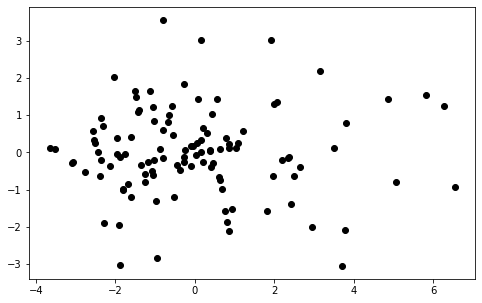

In [22]:
plt.figure(figsize=(8,5))
plt.scatter(data_pca[:,0], data_pca[:,1], c="black")
plt.savefig("images/pca_viz.png")
plt.show()

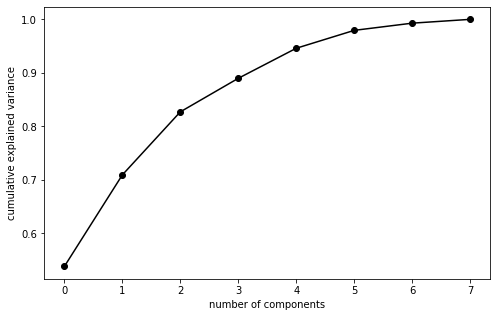

In [23]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), "-o", c="black")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.savefig("images/pca_cumexpvar.png")

plt.show()

Biplot reference: https://github.com/teddyroland/python-biplot/blob/master/biplot.py

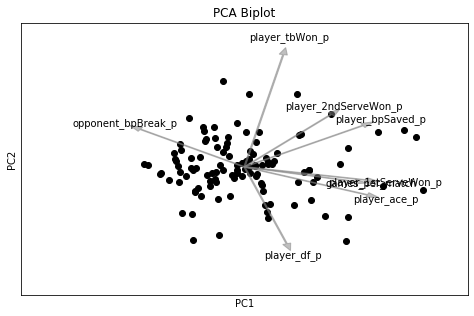

In [24]:
score = data_pca[:,0:2]
coeff = np.transpose(pca.components_[0:2, :])
arw_lbl = data.drop('player_name', axis=1).columns
scalex = 1.0/(score[:,0].max() - score[:,0].min())
scaley = 1.0/(score[:,1].max() - score[:,1].min())

plt.figure(figsize=(8,5))
plt.scatter(score[:,0] * scalex, score[:,1] * scaley, c="black")

for i in range(coeff.shape[0]):
    plt.arrow(0, 0, coeff[i,0], coeff[i,1],
              color = 'gray',alpha = 0.5, width=0.005, head_width=0.03)
    
    if arw_lbl is None:
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15,
                 "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
    else:
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15,
                 arw_lbl[i], color = 'black', ha = 'center', va = 'center')
            
plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.9)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title("PCA Biplot")
plt.xticks(())
plt.yticks(())

plt.savefig("images/pca_biplot.png")

plt.show()

Looking at the directions in the biplot we can see that players that break a lot of their oppenent' serves (i.e.: high opponent_bpBreak_p) are the ones that also have the lowest percentage of aces, for example.

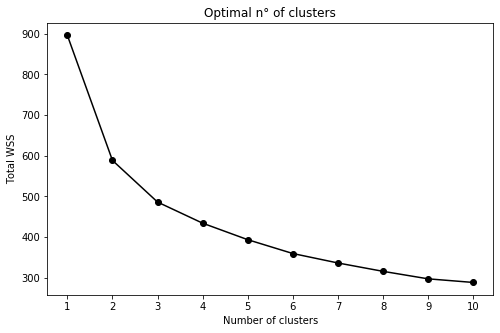

In [25]:
ks = range(1, 11)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(pd.DataFrame(data_scaled))
    inertias.append(model.inertia_)
    
plt.figure(figsize=(8,5))
plt.plot(ks, inertias, '-o', c="black")
# if we want to plot a vert line to indicate the best n of clusters
#plt.axvline(x=4, color='gray',linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Total WSS')
plt.xticks(ks)
plt.title("Optimal n° of clusters")

plt.savefig("images/optimal_n_cluster.png")

plt.show()

Following the elbow rule, the optimal number of cluster should be 4.

We'll now proceed to run the clustering algorithms

## K-Means

In [26]:
kmeans = KMeans(n_clusters=4, n_init=200, max_iter=500, n_jobs=-1)
kmeans.fit(data_scaled)
y_km = kmeans.predict(data_scaled)

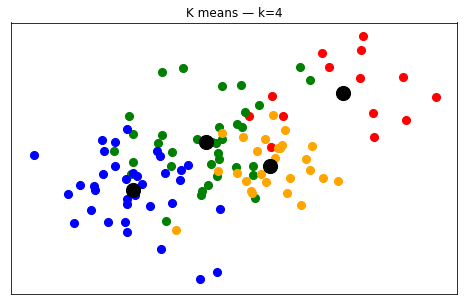

In [27]:
plt.figure(figsize=(8,5))

plt.scatter(data_scaled[y_km ==0,0], data_scaled[y_km == 0,1], s=65, c='red')
plt.scatter(data_scaled[y_km ==1,0], data_scaled[y_km == 1,1], s=65, c='green')
plt.scatter(data_scaled[y_km ==2,0], data_scaled[y_km == 2,1], s=65, c='blue')
plt.scatter(data_scaled[y_km ==3,0], data_scaled[y_km == 3,1], s=65, c='orange')
plt.scatter(data_scaled[y_km ==4,0], data_scaled[y_km == 4,1], s=65, c='cyan')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200)

plt.title("K means — k=" + str(kmeans.n_clusters))
plt.xticks(())
plt.yticks(())

plt.savefig("images/kmeans.png")

plt.show()

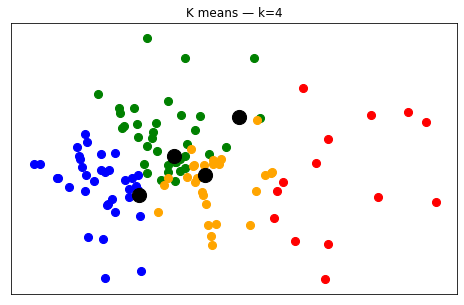

In [28]:
plt.figure(figsize=(8,5))
plt.scatter(data_pca[y_km ==0,0], data_pca[y_km == 0,1], s=65, c='red')
plt.scatter(data_pca[y_km ==1,0], data_pca[y_km == 1,1], s=65, c='green')
plt.scatter(data_pca[y_km ==2,0], data_pca[y_km == 2,1], s=65, c='blue')
plt.scatter(data_pca[y_km ==3,0], data_pca[y_km == 3,1], s=65, c='orange')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200)
plt.title("K means — k=" + str(kmeans.n_clusters))
plt.xticks(())
plt.yticks(())
plt.savefig("images/kmeans_pca.png")
plt.show()

In [29]:
warnings.filterwarnings("ignore")

In [30]:
silhs, cals, davies = [], [], []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, n_init=200, max_iter=500, n_jobs=-1)
    kmeans.fit(data_scaled)
    lbls = kmeans.predict(data_scaled)
    
    silhs.append(metrics.silhouette_score(data_scaled, lbls))
    cals.append(metrics.calinski_harabaz_score(data_scaled, lbls))
    davies.append(metrics.davies_bouldin_score(data_scaled, lbls))

evals_df_kmeans = pd.DataFrame(list(zip(silhs, cals, davies)), 
                               columns = ['Silhouette', "Calinski", "Davies"], index = range(2,11))

In [31]:
warnings.filterwarnings("default")

## Dendograms

In [32]:
linkages = ["average", "single", "ward", "complete"]

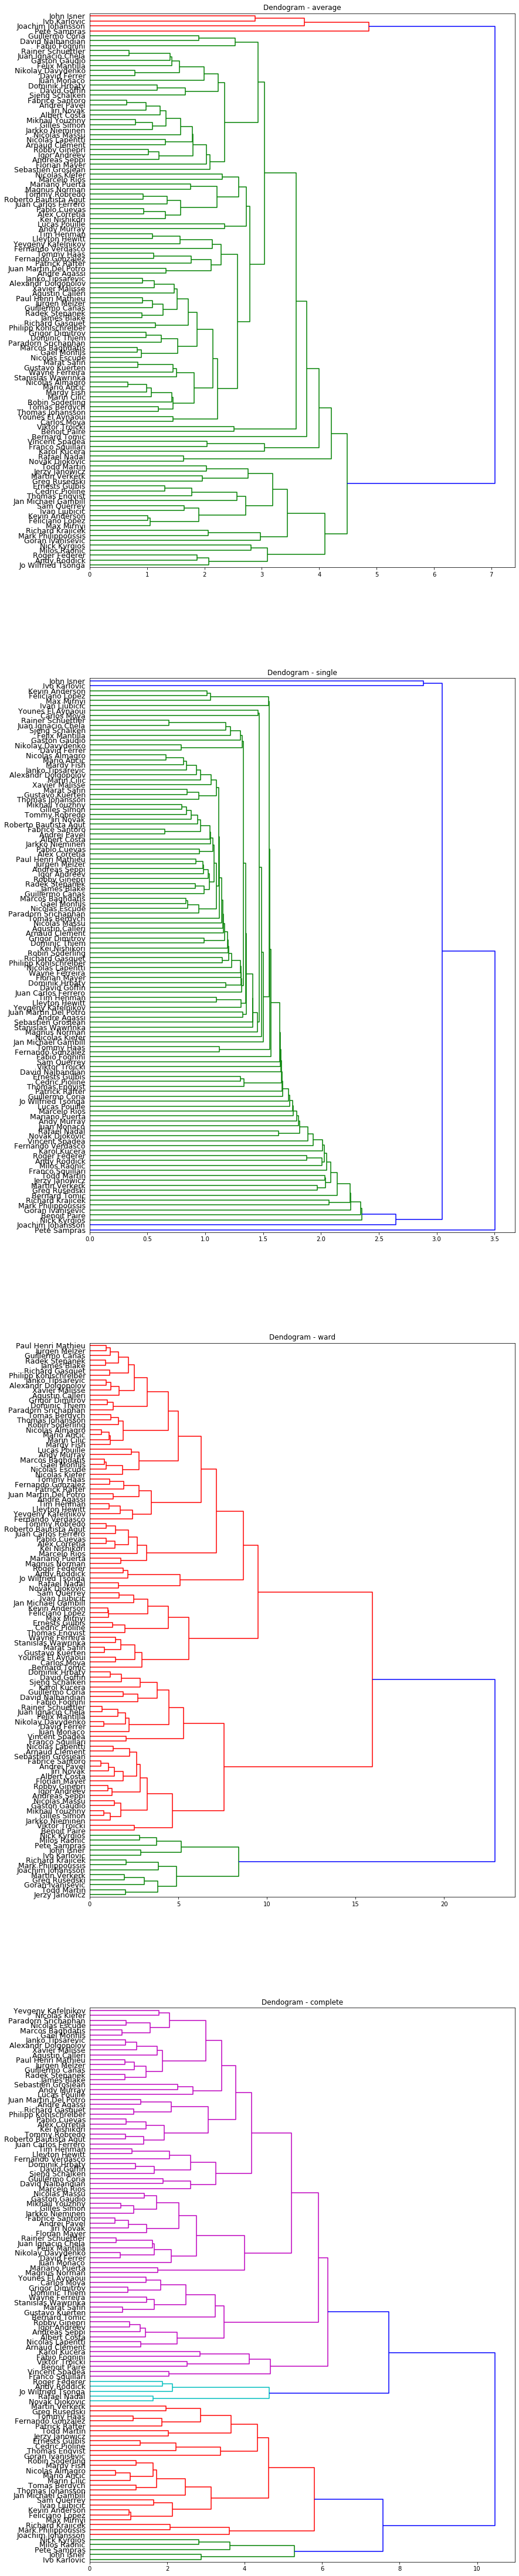

In [33]:
plt.figure(figsize=(13,80))

for i in range(0,4):
    plt.subplot(4,1,i+1)
    plt.title("Dendogram - " + str(linkages[i]))
    
    sch.dendrogram(sch.linkage(data_scaled, method=linkages[i]), labels=np.asarray(players),
                   orientation="right", leaf_font_size=12.5)

plt.savefig("images/dendograms.png")
plt.show()

## Agglomerative

In [34]:
affinities = ["euclidean", "l1", "l2", "manhattan", "cosine"]

In [35]:
hc = AgglomerativeClustering(n_clusters=4, affinity = affinities[0], linkage = linkages[0])

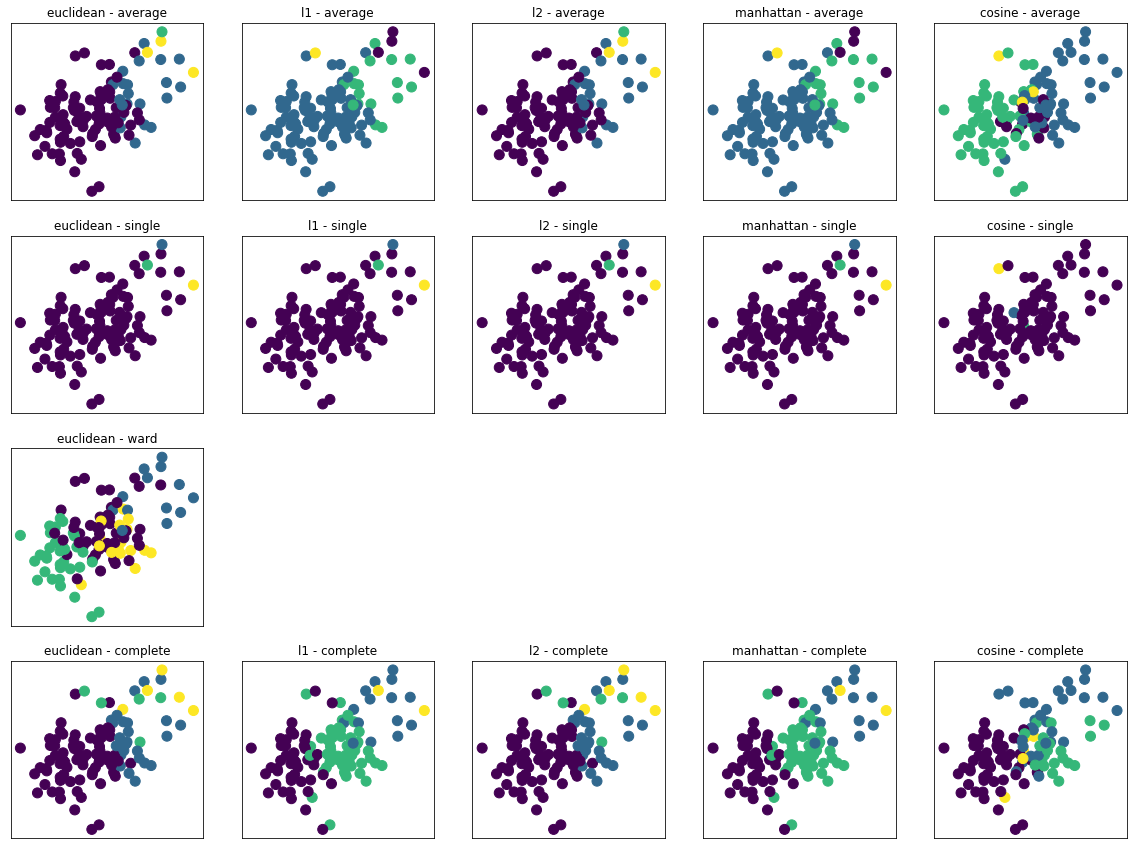

In [36]:
plt.figure(figsize=(20,15))

counter = 0

for i in range(0,4):
    for a in range(0,5):
        counter += 1
        
        if (linkages[i] == "ward") & (affinities[a] != "euclidean"):
            continue
            
        hc = AgglomerativeClustering(n_clusters=4, affinity = affinities[a], linkage = linkages[i])
        y_hc = hc.fit_predict(data_scaled)
        
        plt.subplot(4,5,counter)
        plt.scatter(data_scaled[:,0], data_scaled[:,1], c=y_hc, s=100)
        plt.title(str(affinities[a]) + " - " + str(linkages[i]))
        plt.xticks(())
        plt.yticks(())

plt.savefig("images/agglomerative.png")
        
plt.show()

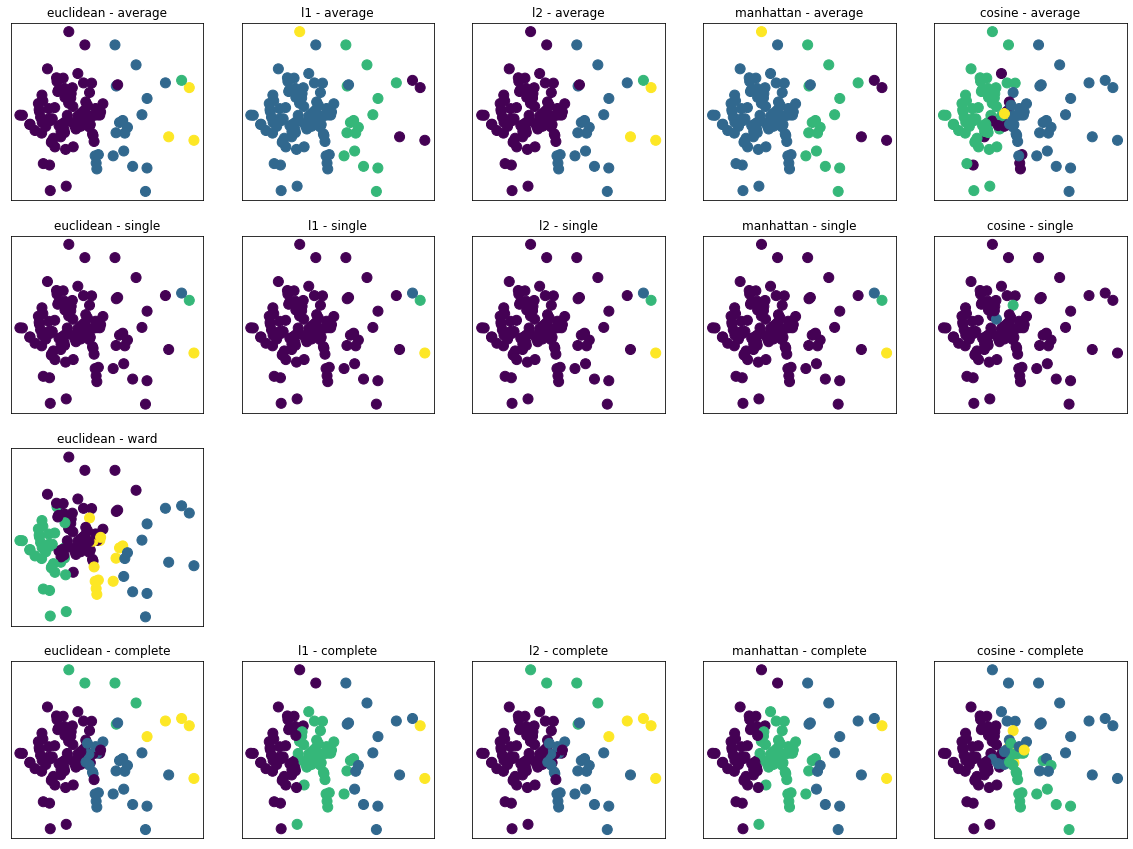

In [37]:
plt.figure(figsize=(20,15))

counter = 0

for i in range(0,4):
    for a in range(0,5):
        counter += 1
        
        if (linkages[i] == "ward") & (affinities[a] != "euclidean"):
            continue
            
        hc = AgglomerativeClustering(n_clusters=4, affinity = affinities[a], linkage = linkages[i])
        y_hc = hc.fit_predict(data_scaled)
        
        plt.subplot(4,5,counter)
        plt.scatter(data_pca[:,0], data_pca[:,1], c=y_hc, s=100)
        plt.title(str(affinities[a]) + " - " + str(linkages[i]))
        plt.xticks(())
        plt.yticks(())

plt.savefig("images/agglomerative_pca.png")
        
plt.show()

In [38]:
warnings.filterwarnings("ignore")

In [39]:
silhs, cals, davies, n_clusters, ac_params = [], [], [], [], []

for i in range(0,4):
    for a in range(0,5):
        for c in range(1,11):
            if (linkages[i] == "ward") & (affinities[a] != "euclidean"):
                continue
            
            hc = AgglomerativeClustering(n_clusters=c, affinity = affinities[a], linkage = linkages[i])
            y_hc = hc.fit_predict(data_scaled)          
            
            if len(np.unique(y_hc)) == 1:
                n_clusters.append(c)
                silhs.append(None)
                cals.append(None)
                davies.append(None)
                ac_params.append(str(affinities[a]) + " - " + str(linkages[i]))
            else:
                n_clusters.append(c)
                silhs.append(metrics.silhouette_score(data_scaled, y_hc))
                cals.append(metrics.calinski_harabaz_score(data_scaled, y_hc))
                davies.append(metrics.davies_bouldin_score(data_scaled, y_hc))
                ac_params.append(str(affinities[a]) + " - " + str(linkages[i]))

            
evals_df_ac = pd.DataFrame(list(zip(silhs, cals, davies, n_clusters, ac_params)),
                           columns = ['Silhouette', "Calinski", "Davies", "Clusters", "Params"])

In [40]:
warnings.filterwarnings("default")

## DBSCAN

In [41]:
warnings.filterwarnings("ignore")

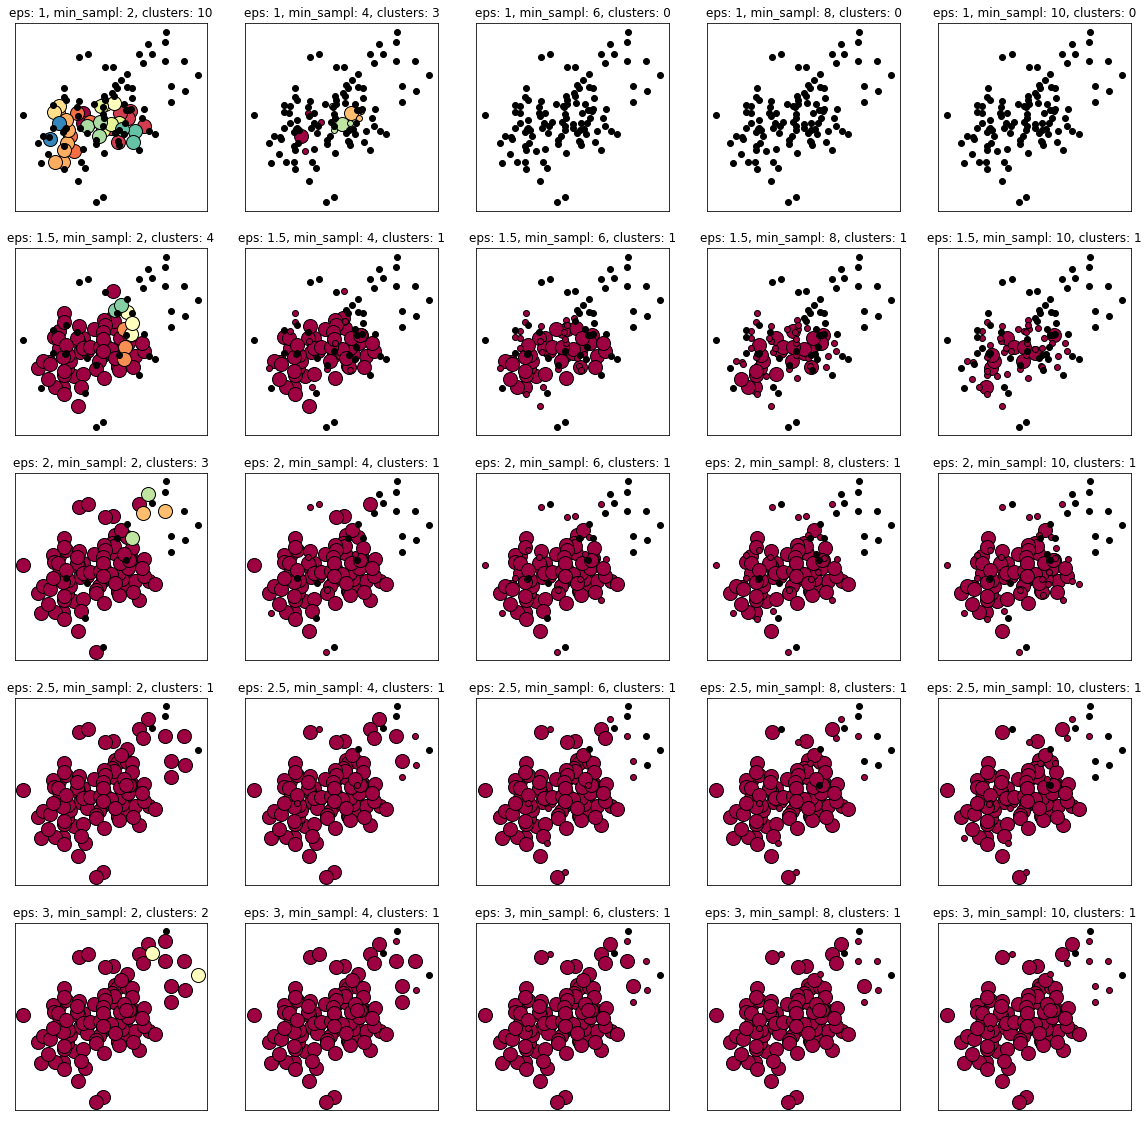

In [42]:
epss = [1,1.5,2,2.5,3]
minsamples = [2,4,6,8,10]
silhs, cals, davies, n_clusters, dbscan_params = [], [], [], [], []
i = 0

plt.figure(figsize=(20,20))
for e in epss:
    for s in minsamples:
        i += 1
        
        db = DBSCAN(eps=e, min_samples=s).fit(data_scaled)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
    
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        
        if len(np.unique(labels)) == 1:
            n_clusters.append(n_clusters_)
            silhs.append(None)
            cals.append(None)
            davies.append(None)
            dbscan_params.append('eps: ' + str(e) + ', min_sampl: '+ str(s))
        else:
            n_clusters.append(n_clusters_)
            silhs.append(metrics.silhouette_score(data_scaled, labels))
            cals.append(metrics.calinski_harabaz_score(data_scaled, labels))
            davies.append(metrics.davies_bouldin_score(data_scaled, labels))
            dbscan_params.append('eps: ' + str(e) + ', min_sampl: '+ str(s))
                
        for k, col in zip(unique_labels, colors):
            if k == -1:
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)
            
            plt.subplot(5,5,i)

            xy = data_scaled[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

            xy = data_scaled[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

            plt.title('eps: ' + str(e) + ', min_sampl: '+ str(s) + ', clusters: %d' % n_clusters_)
            plt.xticks(())
            plt.yticks(())

evals_df_dbscan = pd.DataFrame(list(zip(silhs, cals, davies, n_clusters, dbscan_params)),
                           columns = ['Silhouette', "Calinski", "Davies", "Clusters", "Params"])
            
plt.savefig("images/dbscan.png")
            
plt.show()

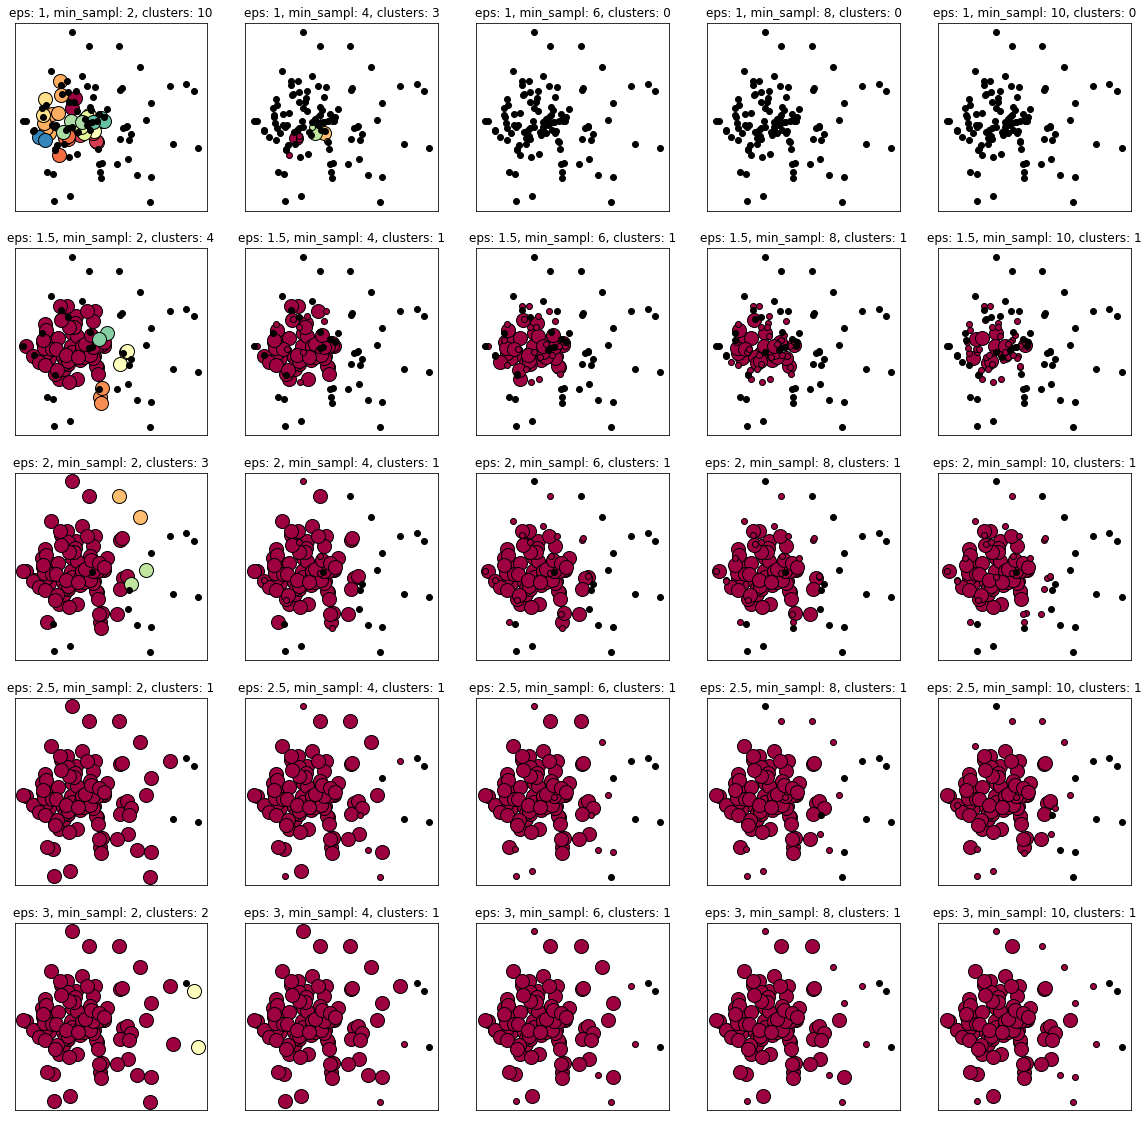

In [43]:
epss = [1,1.5,2,2.5,3]
minsamples = [2,4,6,8,10]
silhs, cals, davies, n_clusters, dbscan_params = [], [], [], [], []
i = 0

plt.figure(figsize=(20,20))
for e in epss:
    for s in minsamples:
        i += 1
        
        db = DBSCAN(eps=e, min_samples=s).fit(data_scaled)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
    
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        
        if len(np.unique(labels)) == 1:
            n_clusters.append(n_clusters_)
            silhs.append(None)
            cals.append(None)
            davies.append(None)
            dbscan_params.append('eps: ' + str(e) + ', min_sampl: '+ str(s))
        else:
            n_clusters.append(n_clusters_)
            silhs.append(metrics.silhouette_score(data_scaled, labels))
            cals.append(metrics.calinski_harabaz_score(data_scaled, labels))
            davies.append(metrics.davies_bouldin_score(data_scaled, labels))
            dbscan_params.append('eps: ' + str(e) + ', min_sampl: '+ str(s))
                
        for k, col in zip(unique_labels, colors):
            if k == -1:
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)
            
            plt.subplot(5,5,i)

            xy = data_pca[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

            xy = data_pca[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

            plt.title('eps: ' + str(e) + ', min_sampl: '+ str(s) + ', clusters: %d' % n_clusters_)
            plt.xticks(())
            plt.yticks(())

evals_df_dbscan = pd.DataFrame(list(zip(silhs, cals, davies, n_clusters, dbscan_params)),
                           columns = ['Silhouette', "Calinski", "Davies", "Clusters", "Params"])
            
plt.savefig("images/dbscan_pca.png")
            
plt.show()

In [44]:
warnings.filterwarnings("default")

## MeanShift

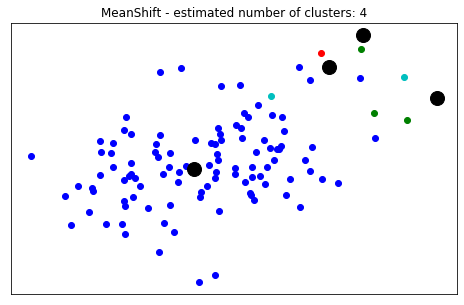

In [45]:
bandwidth = estimate_bandwidth(data_scaled, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data_scaled)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

colors = cycle('bgrcmyk')

plt.figure(figsize=(8,5))

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(data_scaled[my_members, 0], data_scaled[my_members, 1], col + '.', markersize=12)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor="k",
             markeredgecolor='k', markersize=14)

plt.title('MeanShift - estimated number of clusters: %d' % n_clusters_)
plt.xticks(())
plt.yticks(())

plt.savefig("images/meanshift.png")

plt.show()

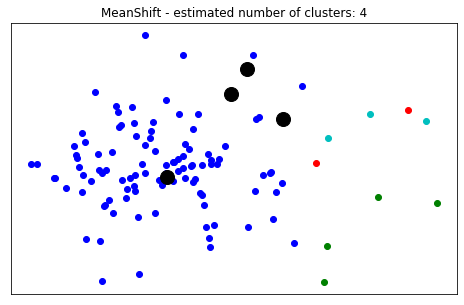

In [46]:
bandwidth = estimate_bandwidth(data_scaled, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data_scaled)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

colors = cycle('bgrcmyk')

plt.figure(figsize=(8,5))

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(data_pca[my_members, 0], data_pca[my_members, 1], col + '.', markersize=12)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor="k",
             markeredgecolor='k', markersize=14)

plt.title('MeanShift - estimated number of clusters: %d' % n_clusters_)
plt.xticks(())
plt.yticks(())

plt.savefig("images/meanshift_pca.png")

plt.show()

In [47]:
warnings.filterwarnings("ignore")

In [48]:
silhs, cals, davies, n_clusters = [], [], [], []
qs = np.linspace(0,1,11)
qs = np.delete(qs, 0)

for i in qs:
    bandwidth = estimate_bandwidth(data_scaled, quantile=i)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data_scaled)
    
    if len(np.unique(ms.labels_)) == 1:
        n_clusters.append(len(np.unique(ms.labels_)))
        silhs.append(None)
        cals.append(None)
        davies.append(None)
    else:
        n_clusters.append(len(np.unique(ms.labels_)))
        silhs.append(metrics.silhouette_score(data_scaled, ms.labels_))
        cals.append(metrics.calinski_harabaz_score(data_scaled, ms.labels_))
        davies.append(metrics.davies_bouldin_score(data_scaled, ms.labels_))

evals_df_ms = pd.DataFrame(list(zip(silhs, cals, davies, n_clusters)),
                           columns = ['Silhouette', "Calinski", "Davies", "Clusters"], index = qs)

In [49]:
warnings.filterwarnings("default")

## Affinity Propagation

In [50]:
warnings.filterwarnings("ignore")

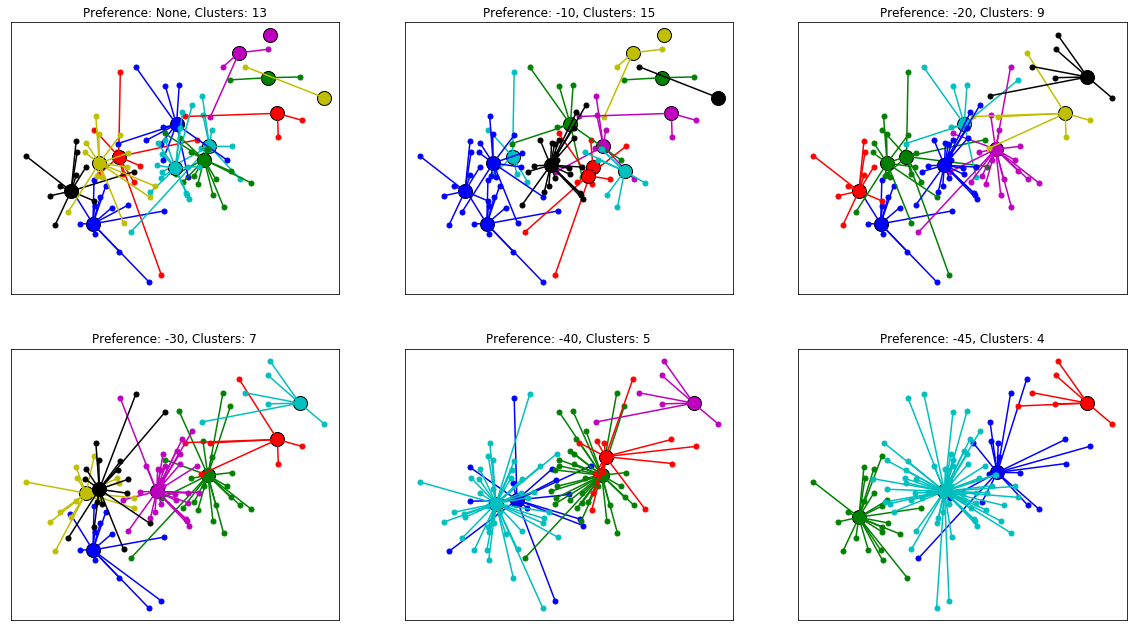

In [51]:
prefs = [None,-10,-20,-30,-40,-45]

silhs, cals, davies, n_clusters = [], [], [], []

plt.figure(figsize=(20,11))

for i in range(0,len(prefs)):
    af = AffinityPropagation(preference=prefs[i]).fit(data_scaled)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_

    n_clusters_ = len(cluster_centers_indices)

    colors = cycle('bgrcmyk')
    
    n_clusters.append(len(af.cluster_centers_indices_))
    
    silhs.append(metrics.silhouette_score(data_scaled, af.labels_))
    cals.append(metrics.calinski_harabaz_score(data_scaled, af.labels_))
    davies.append(metrics.davies_bouldin_score(data_scaled, af.labels_))
    
    plt.subplot(2,3,i+1)
    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = data_scaled[cluster_centers_indices[k]]
        plt.plot(data_scaled[class_members, 0], data_scaled[class_members, 1], col + '.', markersize = 10)
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        
        for x in data_scaled[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title("Preference: " + str(prefs[i]) + ", Clusters: %d" % n_clusters_)
    plt.xticks(())
    plt.yticks(())

evals_df_af = pd.DataFrame(list(zip(silhs, cals, davies, n_clusters)), 
                           columns = ['Silhouette', "Calinski", "Davies", "Clusters"], index = prefs)

plt.savefig("images/affinitypropagation.png")
    
plt.show()

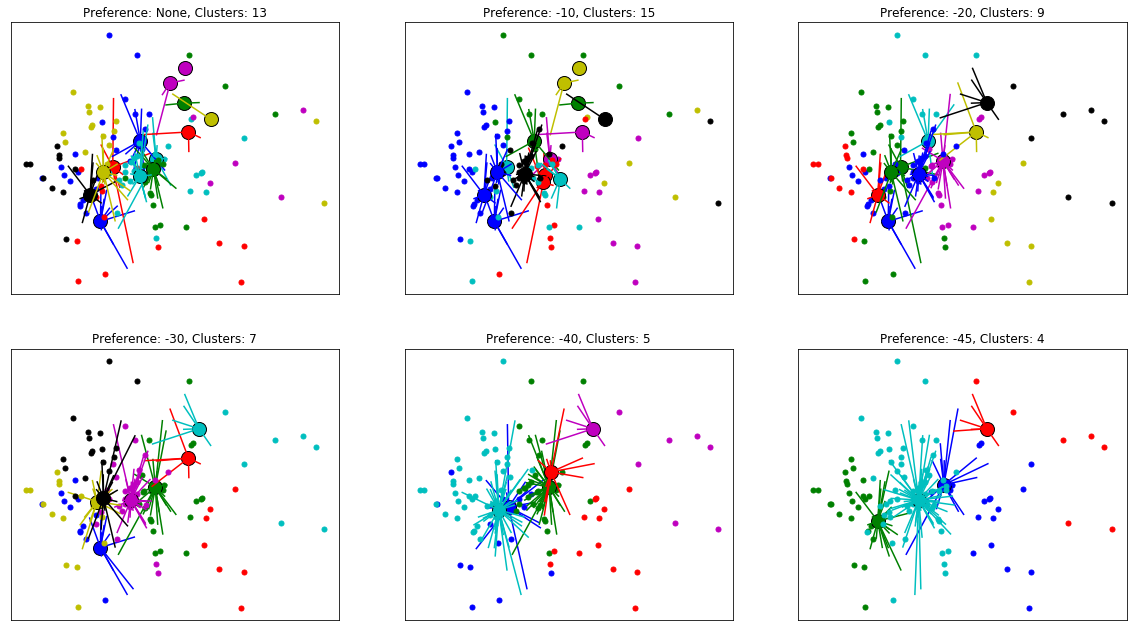

In [52]:
prefs = [None,-10,-20,-30,-40,-45]

silhs, cals, davies, n_clusters = [], [], [], []

plt.figure(figsize=(20,11))

for i in range(0,len(prefs)):
    af = AffinityPropagation(preference=prefs[i]).fit(data_scaled)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_

    n_clusters_ = len(cluster_centers_indices)

    colors = cycle('bgrcmyk')
    
    n_clusters.append(len(af.cluster_centers_indices_))
    
    silhs.append(metrics.silhouette_score(data_scaled, af.labels_))
    cals.append(metrics.calinski_harabaz_score(data_scaled, af.labels_))
    davies.append(metrics.davies_bouldin_score(data_scaled, af.labels_))
    
    plt.subplot(2,3,i+1)
    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = data_scaled[cluster_centers_indices[k]]
        plt.plot(data_pca[class_members, 0], data_pca[class_members, 1], col + '.', markersize = 10)
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        
        for x in data_scaled[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title("Preference: " + str(prefs[i]) + ", Clusters: %d" % n_clusters_)
    plt.xticks(())
    plt.yticks(())

evals_df_af = pd.DataFrame(list(zip(silhs, cals, davies, n_clusters)), 
                           columns = ['Silhouette', "Calinski", "Davies", "Clusters"], index = prefs)

plt.savefig("images/affinitypropagation_pca.png")
    
plt.show()

In [53]:
warnings.filterwarnings("default")

## Clustering evaluation

We do not have ground truth labels. Thus we rely on metrics that can work only on the data and the cluster labels we've predicted.

The Silhouette metric value is between -1 and +1. The higher the better.

A higher Calinski-Harabasz score relates to a model with better defined clusters.

A lower Davies-Bouldin index relates to a model with better separation between the clusters, where 0 is the lowest value.

### k-means

In [54]:
evals_df_kmeans

,Silhouette,Calinski,Davies
2,0.373574,57.470366,1.134313
3,0.203186,46.012035,1.498005
4,0.186916,38.805917,1.527949
5,0.193105,34.746321,1.458092
6,0.183620,31.744696,1.436538
7,0.177764,30.129329,1.436129
8,0.167218,28.375200,1.481063
9,0.179893,26.773895,1.398334
10,0.172045,25.233641,1.443839


In [55]:
print("Best k according to Silhouette: ", evals_df_kmeans["Silhouette"].idxmax())
print("Best k according to Calinski: ", evals_df_kmeans["Calinski"].idxmax())
print("Best k according to Davies: ", evals_df_kmeans["Davies"].idxmin())

Best k according to Silhouette:  2
Best k according to Calinski:  2
Best k according to Davies:  2


### Agglomerative

In [56]:
evals_df_ac

,Silhouette,Calinski,Davies,Clusters,Params
0,NaN,NaN,NaN,1,euclidean - average
1,0.482663,22.074555,0.794725,2,euclidean - average
2,0.457982,12.253671,0.603216,3,euclidean - average
3,0.293802,23.776167,1.042408,4,euclidean - average
4,0.232857,19.953521,0.981802,5,euclidean - average
...,...,...,...,...,...
155,0.044205,18.237701,1.922785,6,cosine - complete
156,0.065885,17.885120,1.747607,7,cosine - complete
157,0.053975,16.454532,1.729493,8,cosine - complete
158,0.082948,19.171756,1.645105,9,cosine - complete


In [57]:
print("Best params according to Silhouette: ", evals_df_ac["Params"][evals_df_ac["Silhouette"].idxmax()],
      ";", "Number of clusters: ", evals_df_ac["Clusters"][evals_df_ac["Silhouette"].idxmax()])
print("Best params according to Calinski: ", evals_df_ac["Params"][evals_df_ac["Calinski"].idxmax()],
      ";", "Number of clusters: ", evals_df_ac["Clusters"][evals_df_ac["Calinski"].idxmax()])
print("Best params according to Davies: ", evals_df_ac["Params"][evals_df_ac["Davies"].idxmin()],
      ";", "Number of clusters: ", evals_df_ac["Clusters"][evals_df_ac["Davies"].idxmin()])

Best params according to Silhouette:  euclidean - average ; Number of clusters:  2
Best params according to Calinski:  l1 - average ; Number of clusters:  2
Best params according to Davies:  euclidean - single ; Number of clusters:  4


### AffinityPropagation

In [58]:
evals_df_af

,Silhouette,Calinski,Davies,Clusters
NaN,0.133937,20.016540,1.386653,13
-10,0.135870,18.813200,1.348274,15
-20,0.139023,24.453369,1.515466,9
-30,0.135992,27.138958,1.627302,7
-40,0.172619,31.374084,1.575656,5
-45,0.163508,32.776436,1.627638,4


In [59]:
print("Best preference according to Silhouette: ", evals_df_af["Silhouette"].idxmax(),
      "-", "Number of clusters: ", evals_df_af["Clusters"][evals_df_af["Silhouette"].idxmax()])
print("Best preference according to Calinski: ", evals_df_af["Calinski"].idxmax(),
      "-", "Number of clusters: ", evals_df_af["Clusters"][evals_df_af["Calinski"].idxmax()])
print("Best preference according to Davies: ", evals_df_af["Davies"].idxmin(),
      "-", "Number of clusters: ", evals_df_af["Clusters"][evals_df_af["Davies"].idxmin()])

Best preference according to Silhouette:  -40 - Number of clusters:  5
Best preference according to Calinski:  -45 - Number of clusters:  4
Best preference according to Davies:  -10 - Number of clusters:  15


### MeanShift

In [60]:
evals_df_ms

,Silhouette,Calinski,Davies,Clusters
0.1,0.132779,11.375256,0.937487,12
0.2,0.282491,13.566385,0.961183,6
0.3,0.387517,14.748138,1.148550,4
0.4,0.439526,34.605205,0.899128,2
0.5,0.439526,34.605205,0.899128,2
0.6,NaN,NaN,NaN,1
0.7,NaN,NaN,NaN,1
0.8,NaN,NaN,NaN,1
0.9,NaN,NaN,NaN,1
1.0,NaN,NaN,NaN,1


In [61]:
print("Best quantile according to Silhouette: ", evals_df_ms["Silhouette"].idxmax(), 
      "-", "Number of clusters: ", evals_df_ms["Clusters"][evals_df_ms["Silhouette"].idxmax()])
print("Best quantile according to Calinski: ", evals_df_ms["Calinski"].idxmax(),
      "-", "Number of clusters: ", evals_df_ms["Clusters"][evals_df_ms["Calinski"].idxmax()])
print("Best quantile according to Davies: ", evals_df_ms["Davies"].idxmin(),
      "-", "Number of clusters: ", evals_df_ms["Clusters"][evals_df_ms["Davies"].idxmin()])

Best quantile according to Silhouette:  0.4 - Number of clusters:  2
Best quantile according to Calinski:  0.4 - Number of clusters:  2
Best quantile according to Davies:  0.4 - Number of clusters:  2


### DBSCAN

In [62]:
evals_df_dbscan

,Silhouette,Calinski,Davies,Clusters,Params
0,-0.220649,1.457846,2.317250,10,"eps: 1, min_sampl: 2"
1,-0.284105,0.822878,2.864810,3,"eps: 1, min_sampl: 4"
2,NaN,NaN,NaN,0,"eps: 1, min_sampl: 6"
3,NaN,NaN,NaN,0,"eps: 1, min_sampl: 8"
4,NaN,NaN,NaN,0,"eps: 1, min_sampl: 10"
5,-0.042029,5.225783,2.948068,4,"eps: 1.5, min_sampl: 2"
6,0.199668,18.472373,2.285292,1,"eps: 1.5, min_sampl: 4"
7,0.190758,18.819906,2.250741,1,"eps: 1.5, min_sampl: 6"
8,0.146031,14.046386,2.541960,1,"eps: 1.5, min_sampl: 8"
9,0.109297,11.306354,2.753586,1,"eps: 1.5, min_sampl: 10"


In [63]:
print("Best params according to Silhouette: ", evals_df_dbscan["Params"][evals_df_dbscan["Silhouette"].idxmax()],
      "-", "Number of clusters: ", evals_df_dbscan["Clusters"][evals_df_dbscan["Silhouette"].idxmax()])
print("Best params according to Calinski: ", evals_df_dbscan["Params"][evals_df_dbscan["Calinski"].idxmax()],
      "-", "Number of clusters: ", evals_df_dbscan["Clusters"][evals_df_dbscan["Calinski"].idxmax()])
print("Best params according to Davies: ", evals_df_dbscan["Params"][evals_df_dbscan["Davies"].idxmin()],
      "-", "Number of clusters: ", evals_df_dbscan["Clusters"][evals_df_dbscan["Davies"].idxmin()])

Best params according to Silhouette:  eps: 3, min_sampl: 4 - Number of clusters:  1
Best params according to Calinski:  eps: 2.5, min_sampl: 10 - Number of clusters:  1
Best params according to Davies:  eps: 3, min_sampl: 2 - Number of clusters:  2


Another metric is Gaps statistics. Taken from: https://anaconda.org/milesgranger/gap-statistic/notebook

In [64]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [65]:
k, gapdf = optimalK(data_scaled, nrefs=3, maxClusters=10)
print('Optimal k is:', k)

Optimal k is: 7


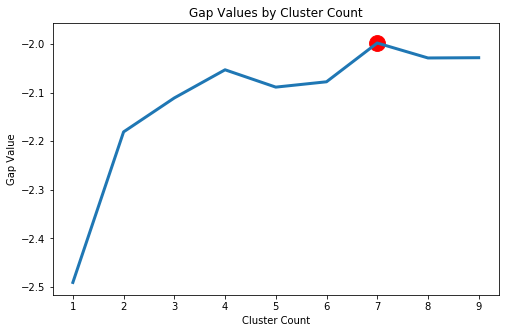

In [66]:
plt.figure(figsize=(8,5))

plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')

plt.savefig("images/gaps_stat.png")

plt.show()

## Results

Let's try to wrap it up

In [67]:
results_c_df = pd.DataFrame({"Silhouette": [evals_df_kmeans["Silhouette"].idxmax(),
                                            evals_df_ac["Clusters"][evals_df_ac["Silhouette"].idxmax()],
                                            evals_df_af["Clusters"][evals_df_af["Silhouette"].idxmax()],
                                            evals_df_ms["Clusters"][evals_df_ms["Silhouette"].idxmax()],
                                            evals_df_dbscan["Clusters"][evals_df_dbscan["Silhouette"].idxmax()]
                                           ],
                             "Calinski": [evals_df_kmeans["Calinski"].idxmax(),
                                          evals_df_ac["Clusters"][evals_df_ac["Calinski"].idxmax()],
                                          evals_df_af["Clusters"][evals_df_af["Calinski"].idxmax()],
                                          evals_df_ms["Clusters"][evals_df_ms["Calinski"].idxmax()],
                                          evals_df_dbscan["Clusters"][evals_df_dbscan["Calinski"].idxmax()]
                                         ],
                             "Davies": [evals_df_kmeans["Davies"].idxmin(),
                                        evals_df_ac["Clusters"][evals_df_ac["Davies"].idxmin()],
                                        evals_df_af["Clusters"][evals_df_af["Davies"].idxmin()],
                                        evals_df_ms["Clusters"][evals_df_ms["Davies"].idxmin()],
                                        evals_df_dbscan["Clusters"][evals_df_dbscan["Davies"].idxmin()]
                                       ]
                            },
                            index = ["kmeans",
                                     "agglomerative",
                                     "affinity propagation",
                                     "mean shift", 
                                     "dbscan"])

results_v_df = pd.DataFrame({"Silhouette": [evals_df_kmeans["Silhouette"][evals_df_kmeans["Silhouette"].idxmax()],
                                            evals_df_ac["Silhouette"][evals_df_ac["Silhouette"].idxmax()],
                                            evals_df_af["Silhouette"][evals_df_af["Silhouette"].idxmax()],
                                            evals_df_ms["Silhouette"][evals_df_ms["Silhouette"].idxmax()],
                                            evals_df_dbscan["Silhouette"][evals_df_dbscan["Silhouette"].idxmax()]
                                           ],
                             "Calinski": [evals_df_kmeans["Calinski"][evals_df_kmeans["Calinski"].idxmax()],
                                          evals_df_ac["Calinski"][evals_df_ac["Calinski"].idxmax()],
                                          evals_df_af["Calinski"][evals_df_af["Calinski"].idxmax()],
                                          evals_df_ms["Calinski"][evals_df_ms["Calinski"].idxmax()],
                                          evals_df_dbscan["Calinski"][evals_df_dbscan["Calinski"].idxmax()]
                                         ],
                             "Davies": [evals_df_kmeans["Davies"][evals_df_kmeans["Davies"].idxmin()],
                                        evals_df_ac["Davies"][evals_df_ac["Davies"].idxmin()],
                                        evals_df_af["Davies"][evals_df_af["Davies"].idxmin()],
                                        evals_df_ms["Davies"][evals_df_ms["Davies"].idxmin()],
                                        evals_df_dbscan["Davies"][evals_df_dbscan["Davies"].idxmin()]
                                       ]
                            },
                            index = ["kmeans",
                                     "agglomerative",
                                     "affinity propagation",
                                     "mean shift", 
                                     "dbscan"])

In [68]:
print("\nNumber of clusters:")
display(results_c_df)
print("\nResults:")
display(results_v_df)


Number of clusters:


,Silhouette,Calinski,Davies
kmeans,2,2,2
agglomerative,2,2,4
affinity propagation,5,4,15
mean shift,2,2,2
dbscan,1,1,2



Results:


,Silhouette,Calinski,Davies
kmeans,0.373574,57.470366,1.134313
agglomerative,0.482663,55.679648,0.348687
affinity propagation,0.172619,32.776436,1.348274
mean shift,0.439526,34.605205,0.899128
dbscan,0.493166,31.912844,0.489615


In [69]:
print("Best algorithm - n°cluster for Silhouette:\n", results_v_df["Silhouette"].idxmax(),
      "-", evals_df_dbscan["Clusters"][evals_df_dbscan["Silhouette"].idxmax()], "cluster(s)")

Best algorithm - n°cluster for Silhouette:
 dbscan - 1 cluster(s)


In [70]:
print("Best algorithm - n°cluster for Calinski:\n", results_v_df["Calinski"].idxmax(),
      "-", evals_df_kmeans["Calinski"].idxmax(), "cluster(s)")

Best algorithm - n°cluster for Calinski:
 kmeans - 2 cluster(s)


In [71]:
print("Best algorithm - n°cluster for Davies:\n", results_v_df["Davies"].idxmin(),
      "-", evals_df_ac["Clusters"][evals_df_ac["Davies"].idxmin()], "cluster(s)")

Best algorithm - n°cluster for Davies:
 agglomerative - 4 cluster(s)


In [72]:
print("Best k for kmeans according to Gaps statistics:", k)

Best k for kmeans according to Gaps statistics: 7
